# Install dependencies

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde 
from matplotlib.lines import Line2D    


# Download the data

In [ ]:
# Prompt the user to enter the full path to the data directory
base_dir = Path(input("Please enter the full path to your data directory: "))

# Verify that the parent of the entered path exists
if not base_dir.parent.exists():
    raise FileNotFoundError(f"The specified path {base_dir.parent} does not exist.")
else:
    # Create the last folder if it doesn't exist
    base_dir.mkdir(parents=True, exist_ok=True)
    print(f"Using data directory: {base_dir}")
!pip install osfclient
# Clone the OSF project into the specified directory
!osf -u USERNAME -p 9xwhz clone "{base_dir}"


# Impact of susceptibility anisotropy


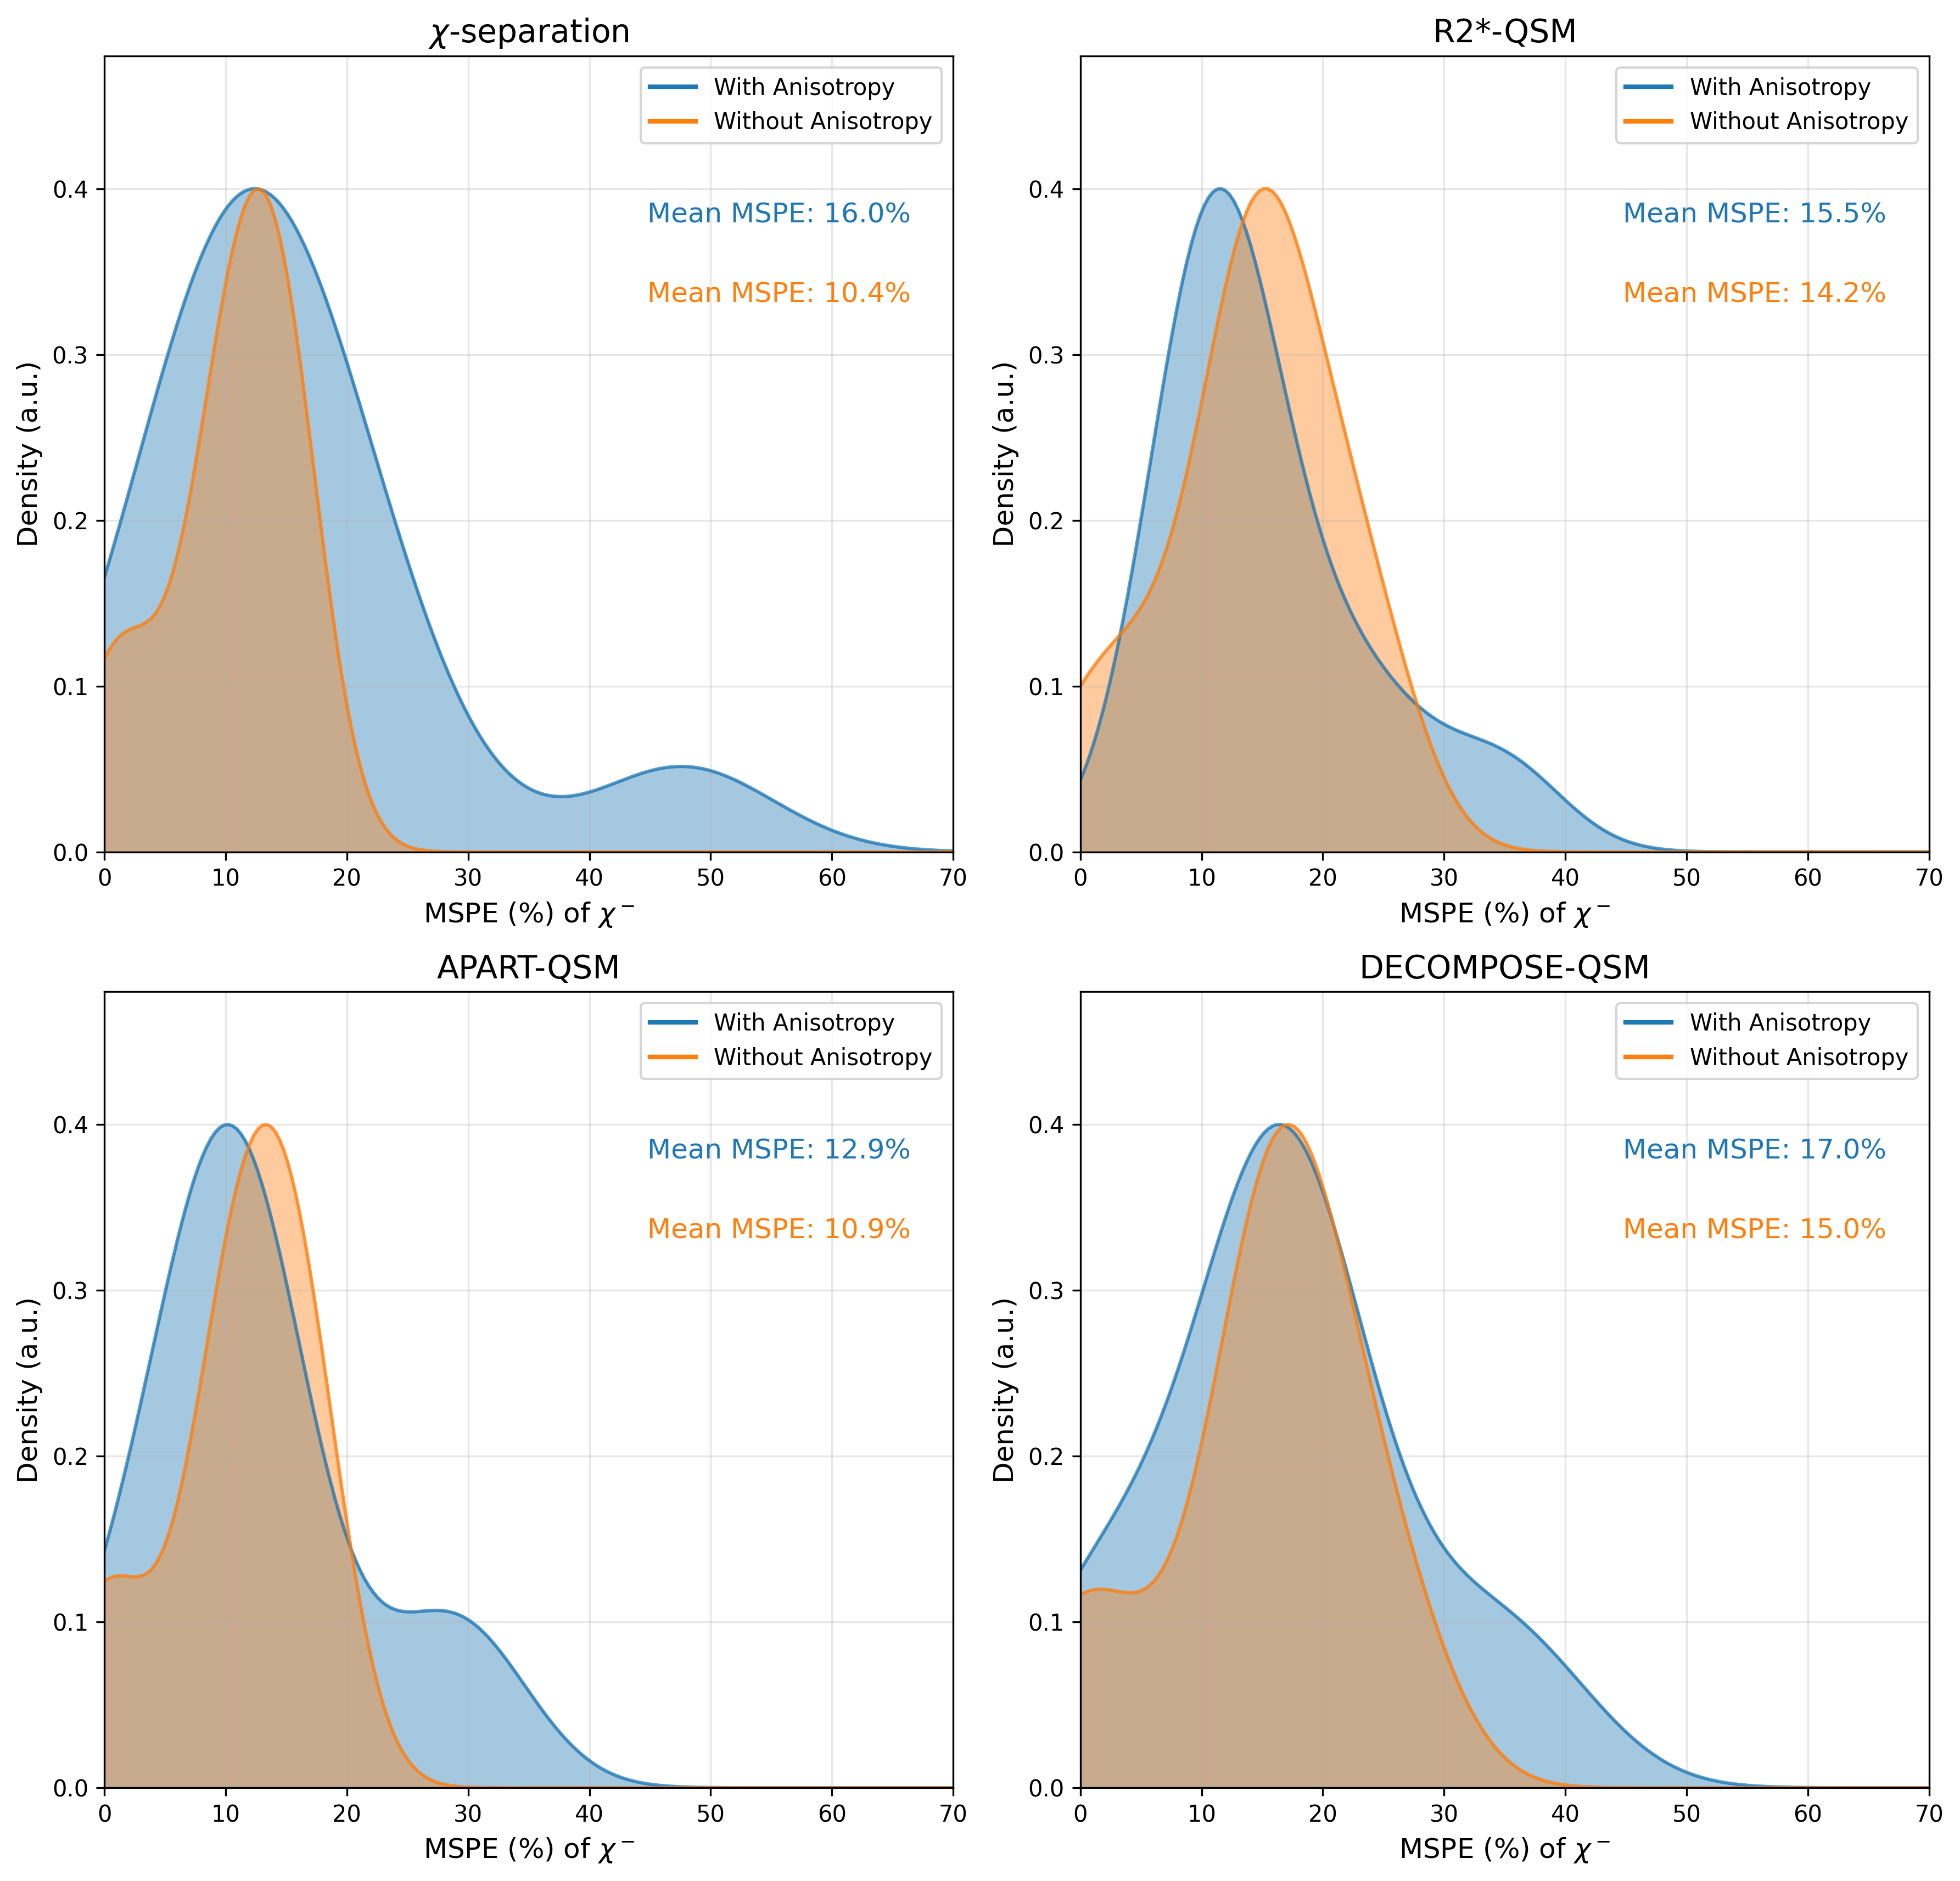

In [ ]:

# ---------------------------
# Parameters and File Paths
# ---------------------------
num_algorithms = 4
algorithm_names = [
    '$\\chi$-separation', 
    'R2*-QSM', 
    'APART-QSM', 
    'DECOMPOSE-QSM'
]

# Load segmentation mask (assumed to contain region labels 1 to 11)
segmentation2_path = base_dir / 'osfstorage' / 'Masks' / 'white_matter_mask.nii.gz'
segmentation2 = nib.load(segmentation2_path).get_fdata()
region_labels = list(range(1, 12))  # regions 1 to 11

# Load simulated maps (common for all algorithms)
simulated_with_path = base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'Chi_negative_with_anisotropy.nii.gz'
simulated_without_path = base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'Chi_negative.nii.gz'
simulated_with = nib.load(simulated_with_path).get_fdata()
simulated_without = nib.load(simulated_without_path).get_fdata()

# Define measured maps for each algorithm
measured_maps = {
    0: {  # Algorithm 1: χ-separation
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'With_anisotropy' / 'ChiNegMap.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'Without_anisotropy' / 'ChiNegMap.nii',
    },
    1: {  # Algorithm 2: R2*-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'With_anisotropy' / 'ChiNegMap.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'Without_anisotropy' / 'ChiNegMap.nii',
    },
    2: {  # Algorithm 3: APART-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'With_anisotropy' / 'X_dia_abs.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'Without_anisotropy' / 'X_dia_abs.nii',
    },
    3: {  # Algorithm 4: DECOMPOSE-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'With_anisotropy' / 'Results_DCS_abs.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'Without_anisotropy' / 'results_DCS_abs.nii',
    },
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi=300)
t_test_results = {}
for idx in range(num_algorithms):
    ax = axes[idx // 2, idx % 2]
    algorithm_name = algorithm_names[idx]
    
    measured_with = nib.load(measured_maps[idx]['x_minus_with_anisotropy']).get_fdata() * -1
    measured_without = nib.load(measured_maps[idx]['x_minus_without_anisotropy']).get_fdata() * -1

    errors_with_regions = []
    errors_without_regions = []
    
    for region in region_labels:
        region_mask = segmentation2 == region
        if np.any(region_mask):
            # For "With Anisotropy"
            sim_val_with = np.mean(simulated_with[region_mask])
            meas_val_with = np.mean(measured_with[region_mask])
            if sim_val_with != 0:
                error_with = ((meas_val_with - sim_val_with) / sim_val_with) ** 2 * 100
            else:
                error_with = np.nan
            
            # For "Without Anisotropy"
            sim_val_without = np.mean(simulated_without[region_mask])
            meas_val_without = np.mean(measured_without[region_mask])
            if sim_val_without != 0:
                error_without = ((meas_val_without - sim_val_without) / sim_val_without) ** 2 * 100
            else:
                error_without = np.nan
            
            errors_with_regions.append(error_with)
            errors_without_regions.append(error_without)
   
    errors_with_regions = np.array(errors_with_regions)
    errors_without_regions = np.array(errors_without_regions)
    errors_with_regions = errors_with_regions[~np.isnan(errors_with_regions)]
    errors_without_regions = errors_without_regions[~np.isnan(errors_without_regions)]

    x_vals = np.linspace(0, 70, 200)  
    max_height = 0.4  
    
    # Plot KDE for "With Anisotropy"
    if errors_with_regions.size > 1:
        kde_with = gaussian_kde(errors_with_regions)
        density_with = kde_with(x_vals)
        scaling_with = max_height / np.max(density_with) if np.max(density_with) > 0 else 1
        density_with_scaled = density_with * scaling_with
        ax.fill_between(x_vals, 0, density_with_scaled, color='tab:blue', alpha=0.4)
        ax.plot(x_vals, density_with_scaled, color='tab:blue', alpha=0.7)
        mean_mspe_with = np.mean(errors_with_regions)
    elif errors_with_regions.size == 1:
        mean_mspe_with = errors_with_regions[0]
        ax.plot([mean_mspe_with], [max_height/2], marker='o', color='tab:blue')
    else:
        mean_mspe_with = None  # no data available

    # Plot KDE for "Without Anisotropy"
    if errors_without_regions.size > 1:
        kde_without = gaussian_kde(errors_without_regions)
        density_without = kde_without(x_vals)
        scaling_without = max_height / np.max(density_without) if np.max(density_without) > 0 else 1
        density_without_scaled = density_without * scaling_without
        ax.fill_between(x_vals, 0, density_without_scaled, color='tab:orange', alpha=0.4)
        ax.plot(x_vals, density_without_scaled, color='tab:orange', alpha=0.7)
        mean_mspe_without = np.mean(errors_without_regions)
    elif errors_without_regions.size == 1:
        mean_mspe_without = errors_without_regions[0]
        ax.plot([mean_mspe_without], [max_height/2], marker='o', color='tab:orange')
    else:
        mean_mspe_without = None

    if mean_mspe_with is not None:
        ax.text(0.95, 0.8, f"Mean MSPE: {mean_mspe_with:.1f}%", transform=ax.transAxes,
                color='tab:blue', ha='right', va='center', fontsize=12)
    if mean_mspe_without is not None:
        ax.text(0.95, 0.7, f"Mean MSPE: {mean_mspe_without:.1f}%", transform=ax.transAxes,
                color='tab:orange', ha='right', va='center', fontsize=12)
    
    # ------------------------------------------------
    # Create and add a legend for the subplot
    # ------------------------------------------------
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=2, label='With Anisotropy'),
        Line2D([0], [0], color='tab:orange', lw=2, label='Without Anisotropy')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title and axis labels.
    ax.set_title(algorithm_name, fontsize=14)
    ax.set_xlabel("MSPE (%) of $\\chi^-$", fontsize=12)
    ax.set_ylabel("Density (a.u.)", fontsize=12)
    ax.set_xlim(0, 70)
    ax.set_ylim(0, max_height * 1.2)
    ax.grid(alpha=0.3)

# ---------------------------
# Final figure adjustments
# ---------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Impact of noise

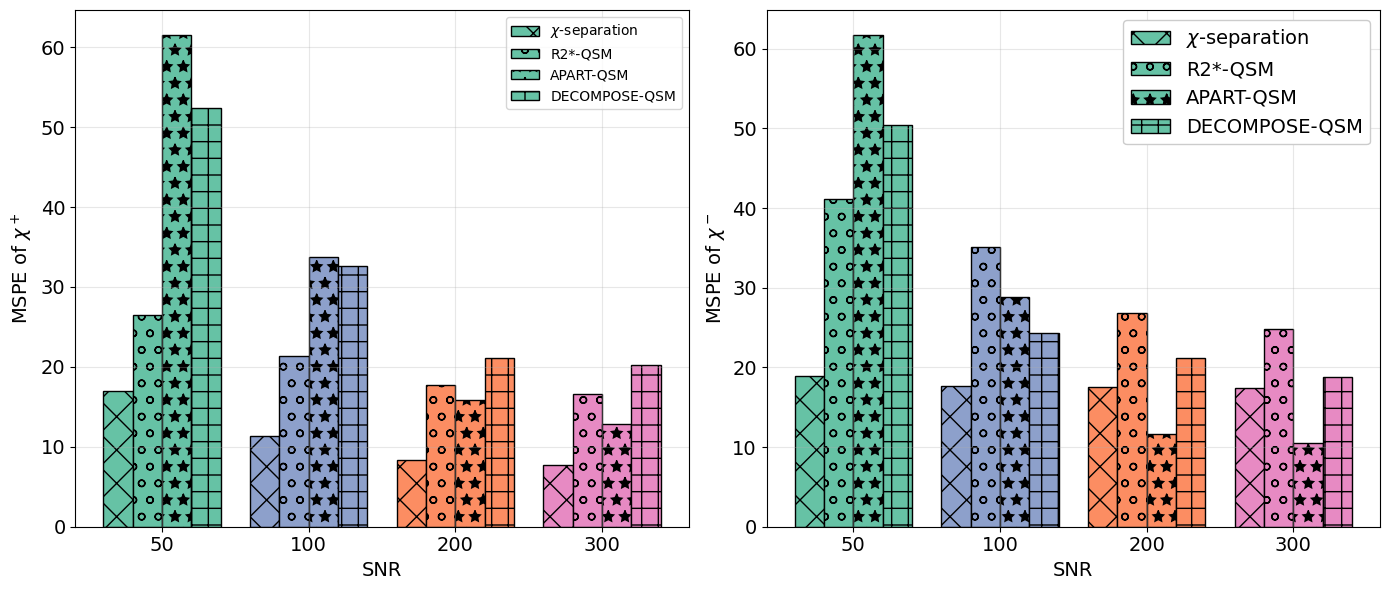

In [4]:
# Define algorithms and SNR levels
algorithms = ['$\\chi$-separation', 'R2*-QSM', 'APART-QSM', 'DECOMPOSE-QSM']
snr_levels = [50, 100, 200, 300]

# Initialize dictionaries to store errors
x_positive_errors = {alg: [] for alg in algorithms}
x_negative_errors = {alg: [] for alg in algorithms}


def construct_path(*args):
    return base_dir / 'osfstorage' / Path(*args)

# Load the simulated maps
simulated_positive_path = construct_path('Susceptibility_Separation_Results', 'Chi_positive.nii.gz')
simulated_negative_path = construct_path('Susceptibility_Separation_Results', 'Chi_negative_with_anisotropy.nii.gz')
simulated_positive = nib.load(simulated_positive_path).get_fdata()
simulated_negative = nib.load(simulated_negative_path).get_fdata()

# Load the segmentation masks
segmentation_positive_path = construct_path('Masks', 'SegmentedModel.nii.gz')
segmentation_negative_path = construct_path('Masks', 'white_matter_mask.nii.gz')
segmentation_positive = nib.load(segmentation_positive_path).get_fdata()
segmentation_negative = nib.load(segmentation_negative_path).get_fdata()

# Specify the measured maps file paths individually
measured_maps_positive = {
    '$\\chi$-separation': {
        300: construct_path('Noise', 'X-separation', 'SNR_300', 'ChiPosMap.nii.gz'),
        200: construct_path('Noise', 'X-separation', 'SNR_200', 'ChiPosMap.nii.gz'),
        100: construct_path('Noise', 'X-separation', 'SNR_100', 'ChiPosMap.nii.gz'),
        50:  construct_path('Noise', 'X-separation', 'SNR_50', 'ChiPosMap.nii.gz'),
    },
    'R2*-QSM': {
        300: construct_path('Noise', 'R2star-QSM', 'SNR_300', 'ChiPosMap.nii.gz'),
        200: construct_path('Noise', 'R2star-QSM', 'SNR_200', 'ChiPosMap.nii.gz'),
        100: construct_path('Noise', 'R2star-QSM', 'SNR_100', 'ChiPosMap.nii.gz'),
        50:  construct_path('Noise', 'R2star-QSM', 'SNR_50', 'ChiPosMap.nii.gz'),
    },
    'APART-QSM': {
        300: construct_path('Noise', 'APART-QSM', 'SNR_300', 'X_para.nii.gz'),
        200: construct_path('Noise', 'APART-QSM', 'SNR_200', 'X_para.nii.gz'),
        100: construct_path('Noise', 'APART-QSM', 'SNR_100', 'X_para.nii.gz'),
        50:  construct_path('Noise', 'APART-QSM', 'SNR_50', 'X_para.nii.gz'),
    },
    'DECOMPOSE-QSM': {
        300: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_300', 'results_PCS.nii.gz'),
        200: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_200', 'results_PCS.nii.gz'),
        100: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_100', 'results_PCS.nii.gz'),
        50:  construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_50', 'results_PCS.nii.gz'),
    },
}

measured_maps_negative = {
    '$\\chi$-separation': {
        300: construct_path('Noise', 'X-separation', 'SNR_300', 'ChiNegMap.nii.gz'),
        200: construct_path('Noise', 'X-separation', 'SNR_200', 'ChiNegMap.nii.gz'),
        100: construct_path('Noise', 'X-separation', 'SNR_100', 'ChiNegMap.nii.gz'),
        50:  construct_path('Noise', 'X-separation', 'SNR_50', 'ChiNegMap.nii.gz'),
    },
    'R2*-QSM': {
        300: construct_path('Noise', 'R2star-QSM', 'SNR_300', 'ChiNegMap.nii.gz'),
        200: construct_path('Noise', 'R2star-QSM', 'SNR_200', 'ChiNegMap.nii.gz'),
        100: construct_path('Noise', 'R2star-QSM', 'SNR_100', 'ChiNegMap.nii.gz'),
        50:  construct_path('Noise', 'R2star-QSM', 'SNR_50', 'ChiNegMap.nii.gz'),
    },
    'APART-QSM': {
        300: construct_path('Noise', 'APART-QSM', 'SNR_300', 'X_dia_abs.nii.gz'),
        200: construct_path('Noise', 'APART-QSM', 'SNR_200', 'X_dia_abs.nii.gz'),
        100: construct_path('Noise', 'APART-QSM', 'SNR_100', 'X_dia_abs.nii.gz'),
        50:  construct_path('Noise', 'APART-QSM', 'SNR_50', 'X_dia_abs.nii.gz'),
    },
    'DECOMPOSE-QSM': {
        300: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_300', 'results_DCS_abs.nii.gz'),
        200: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_200', 'results_DCS_abs.nii.gz'),
        100: construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_100', 'results_DCS_abs.nii.gz'),
        50:  construct_path('Noise', 'DECOMPOSE-QSM', 'SNR_50', 'results_DCS_abs.nii.gz'),
    },
}

# For each algorithm and SNR level, load the maps individually
for alg in algorithms:
    for snr in snr_levels:
        # Get the file paths
        measured_positive_path = measured_maps_positive[alg][snr]
        measured_negative_path = measured_maps_negative[alg][snr]
        
        # Load the measured maps
        measured_positive = nib.load(measured_positive_path).get_fdata()
        measured_negative = nib.load(measured_negative_path).get_fdata()
        
        # Multiply measured negative map by -1
        measured_negative = -1 * measured_negative
        
        # Positive regions 
        positive_errors = []
        for region in range(1, 10):
            # Create mask for this region
            mask = (segmentation_positive == region)
            
            # Extract mean values
            measured_mean = np.mean(measured_positive[mask])
            simulated_mean = np.mean(simulated_positive[mask])
            
            # Compute error
            error = ((measured_mean - simulated_mean) / simulated_mean) ** 2 * 100
            positive_errors.append(error)
        
        # Compute average error over regions
        avg_positive_error = np.mean(positive_errors)
        x_positive_errors[alg].append(avg_positive_error)
        
        # Negative regions:
        negative_errors = []
        
        # Regions 1 to 9 from segmentation_positive
        for region in range(1, 10):
            # Create mask for this region
            mask = (segmentation_positive == region)
            
            # Extract mean values
            measured_mean = np.mean(measured_negative[mask])
            simulated_mean = np.mean(simulated_negative[mask])
            
            # Compute error
            error = ((measured_mean - simulated_mean) / simulated_mean) ** 2 * 100
            negative_errors.append(error)
        
        # Regions 1 to 10 from segmentation_negative
        for region in range(1, 11):
            # Create mask for this region
            mask = (segmentation_negative == region)
            
            # Extract mean values
            measured_mean = np.mean(measured_negative[mask])
            simulated_mean = np.mean(simulated_negative[mask])
            
            # Compute error
            error = ((measured_mean - simulated_mean) / simulated_mean) ** 2 * 100
            negative_errors.append(error)
        
        # Compute average error over all 19 regions
        avg_negative_error = np.mean(negative_errors)
        x_negative_errors[alg].append(avg_negative_error)

# Define hatch patterns for distinction
hatch_patterns = ['x', 'o', '*', '+']  

# Define color mapping based on SNR
snr_colors = {
    50:  '#66c2a5', 
    100: '#8da0cb', 
    200: '#fc8d62', 
    300: '#e78ac3',  
}

# Bar width and x positions
bar_width = 0.2
snr_index = np.arange(len(snr_levels))

# Figure setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

tick_font_size = 14
legend_font_size = 14

# --- Plot X-positive ---
for i, (alg, hatch) in enumerate(zip(algorithms, hatch_patterns)):
    # For legend clarity: we only label the algorithm on the first SNR iteration
    for j, snr in enumerate(snr_levels):
        # x-coordinate for this bar
        x_coord = snr_index[j] + i * bar_width
        # The MSPE value for this algorithm at the j-th SNR
        y_value = x_positive_errors[alg][j]
       
        # Plot a single bar
        ax1.bar(
            x_coord,
            y_value,
            bar_width,
            label=alg if j == 0 else None,  
            hatch=hatch,
            edgecolor='black',
            color=snr_colors[snr],         
            )

ax1.set_xlabel('SNR', fontsize=tick_font_size)
ax1.set_ylabel('MSPE of $\\chi^+$', fontsize=tick_font_size)

ax1.set_xticks(snr_index + bar_width * 1.5)
ax1.set_xticklabels(snr_levels, fontsize=tick_font_size)
ax1.legend()
ax1.grid(alpha=0.3)

# --- Plot X-negative ---
for i, (alg, hatch) in enumerate(zip(algorithms, hatch_patterns)):
    for j, snr in enumerate(snr_levels):
        x_coord = snr_index[j] + i * bar_width
        y_value = x_negative_errors[alg][j]
        
        ax2.bar(
            x_coord,
            y_value,
            bar_width,
            label=alg if j == 0 else None,
            hatch=hatch,
            edgecolor='black',
            color=snr_colors[snr],
        )

ax2.set_xlabel('SNR', fontsize=tick_font_size)
ax2.set_ylabel('MSPE of $\\chi^-$', fontsize=tick_font_size)

ax2.set_xticks(snr_index + bar_width * 1.5)
ax2.set_xticklabels(snr_levels, fontsize=tick_font_size)
ax2.legend(fontsize=legend_font_size, facecolor='white', framealpha=1)
ax2.grid(alpha=0.3)

# Adjust tick sizes
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)

plt.tight_layout()
plt.show()

# Impact of noise on susceptibility anisotorpy

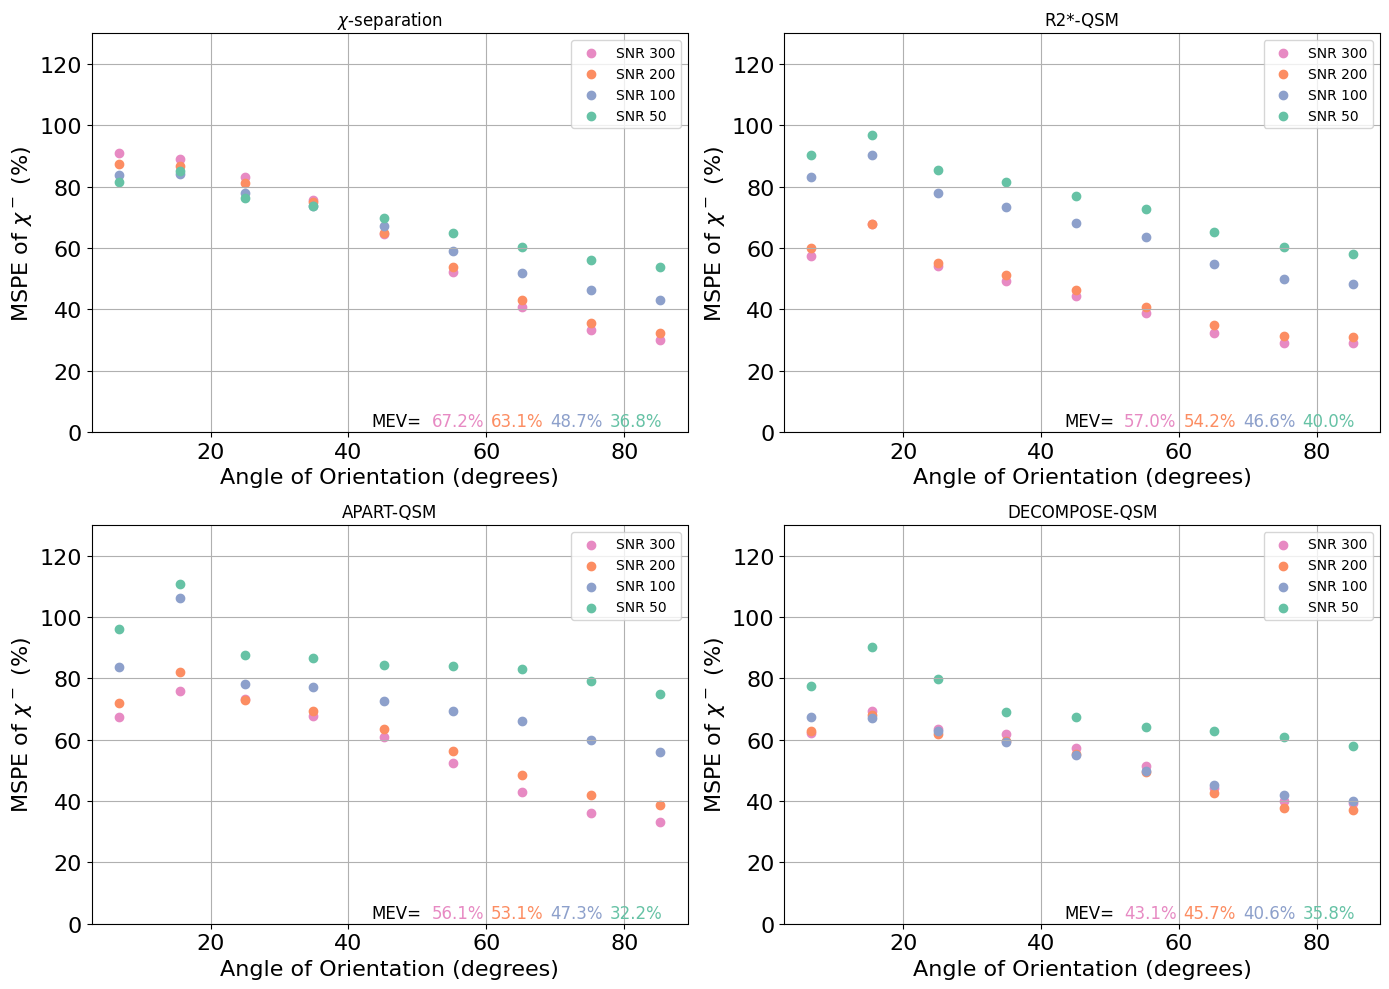

In [ ]:
# Define the algorithms and SNR levels
algorithms = ['x-separation', 'R2*-QSM', 'APART-QSM', 'DECOMPOSE-QSM']
snr_levels = ['SNR 300', 'SNR 200', 'SNR 100', 'SNR 50']


# Initialize a dictionary to store the full paths for measured images
measured_image_paths = {
    'x-separation': {
        'SNR 300': base_dir / 'osfstorage' / 'Noise' / 'X-separation' / 'SNR_300' / 'ChiNegMap.nii.gz',
        'SNR 200': base_dir / 'osfstorage' / 'Noise' / 'X-separation' / 'SNR_200' / 'ChiNegMap.nii.gz',
        'SNR 100': base_dir / 'osfstorage' / 'Noise' / 'X-separation' / 'SNR_100' / 'ChiNegMap.nii.gz',
        'SNR 50': base_dir / 'osfstorage' / 'Noise' / 'X-separation' / 'SNR_50' / 'ChiNegMap.nii.gz',
    },
    'R2*-QSM': {
        'SNR 300': base_dir / 'osfstorage' / 'Noise' / 'R2star-QSM' / 'SNR_300' / 'ChiNegMap.nii.gz',
        'SNR 200': base_dir / 'osfstorage' / 'Noise' / 'R2star-QSM' / 'SNR_200' / 'ChiNegMap.nii.gz',
        'SNR 100': base_dir / 'osfstorage' / 'Noise' / 'R2star-QSM' / 'SNR_100' / 'ChiNegMap.nii.gz',
        'SNR 50': base_dir / 'osfstorage' / 'Noise' / 'R2star-QSM' / 'SNR_50' / 'ChiNegMap.nii.gz',
    },
    'APART-QSM': {
        'SNR 300': base_dir / 'osfstorage' / 'Noise' / 'APART-QSM' / 'SNR_300' / 'X_dia_abs.nii.gz',
        'SNR 200': base_dir / 'osfstorage' / 'Noise' / 'APART-QSM' / 'SNR_200' / 'X_dia_abs.nii.gz',
        'SNR 100': base_dir / 'osfstorage' / 'Noise' / 'APART-QSM' / 'SNR_100' / 'X_dia_abs.nii.gz',
        'SNR 50': base_dir / 'osfstorage' / 'Noise' / 'APART-QSM' / 'SNR_50' / 'X_dia_abs.nii.gz',
    },
    'DECOMPOSE-QSM': {
        'SNR 300': base_dir / 'osfstorage' / 'Noise' / 'DECOMPOSE-QSM' / 'SNR_300' / 'results_DCS_abs.nii.gz',
        'SNR 200': base_dir / 'osfstorage' / 'Noise' / 'DECOMPOSE-QSM' / 'SNR_200' / 'results_DCS_abs.nii.gz',
        'SNR 100': base_dir / 'osfstorage' / 'Noise' / 'DECOMPOSE-QSM' / 'SNR_100' / 'results_DCS_abs.nii.gz',
        'SNR 50': base_dir / 'osfstorage' / 'Noise' / 'DECOMPOSE-QSM' / 'SNR_50' / 'results_DCS_abs.nii.gz',
    },
}

# ----------------------------
# 2) LOAD NIFTI DATA
# ----------------------------

# Load simulated (ground truth) chi, theta, and segmentation images
simulated_nii = nib.load(base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'Chi_negative_with_anisotropy.nii.gz')
simulated_img_with_anisotropy = simulated_nii.get_fdata()

theta_nii = nib.load(base_dir / 'osfstorage' / 'Noise' / 'theta.nii.gz')
theta_img = theta_nii.get_fdata()
theta_img[np.isnan(theta_img)] = 0

segmentation_nii = nib.load(base_dir / 'osfstorage' / 'Masks' / 'WM_fibers_seg.nii.gz')
segmentation_img = segmentation_nii.get_fdata()

theta_shape = theta_nii.shape
theta_affine = theta_nii.affine

# Load measured images for each algorithm and SNR
measured_images = {}
for algorithm in algorithms:
    measured_images[algorithm] = {}
    for snr in snr_levels:
        path = measured_image_paths[algorithm][snr]
        measured_images[algorithm][snr] = nib.load(path).get_fdata()

# ----------------------------
# 3) GATHER VALID VOXELS & COMPUTE ERRORS
# ----------------------------

all_valid_coords = []  
all_theta_values = []
all_sim_values = []

errors = {
    algorithm: {
        snr: [] for snr in snr_levels
    }
    for algorithm in algorithms
}

# Loop over the segmentation regions 
for region in range(1, 28):
    # Region mask
    region_mask = (segmentation_img == region)
    region_valid_mask = region_mask & (theta_img != 0)
    
    # Get the 3D coordinates of those valid voxels
    valid_coords = np.argwhere(region_valid_mask)
    if valid_coords.size == 0:
        continue  

    # Extract the actual voxel values
    region_theta_vals = theta_img[region_valid_mask]
    region_sim_vals = simulated_img_with_anisotropy[region_valid_mask] * -1

    # Append these to our global lists
    all_valid_coords.append(valid_coords)
    all_theta_values.append(region_theta_vals)
    all_sim_values.append(region_sim_vals)

    # For each algorithm & SNR, calculate MSPE in this region and append
    for algorithm in algorithms:
        for snr in snr_levels:
            measured_vals = measured_images[algorithm][snr][region_valid_mask]
            epsilon = 1e-10  
            relative_squared_error = np.sqrt(
            np.square(region_sim_vals - measured_vals) /
            (np.square(region_sim_vals) + epsilon)
            ) * 100
            errors[algorithm][snr].append(relative_squared_error)

all_valid_coords = np.concatenate(all_valid_coords, axis=0)
all_theta_values = np.concatenate(all_theta_values, axis=0)
all_sim_values = np.concatenate(all_sim_values, axis=0)

for algorithm in algorithms:
    for snr in snr_levels:
        errors[algorithm][snr] = np.concatenate(errors[algorithm][snr], axis=0)

# ----------------------------
# 4) BIN THE THETA VALUES 
# ----------------------------

bins = np.arange(0, 100, 10)  

bin_indices = np.digitize(all_theta_values, bins)  
num_bins = len(bins) - 1  

# Calculate the mean bin angle
bin_means_theta = []
for b in range(1, len(bins)):
    mask_b = (bin_indices == b)
    if np.any(mask_b):
        bin_means_theta.append(np.mean(all_theta_values[mask_b]))
bin_means_theta = np.array(bin_means_theta)

# ----------------------------
# 5) CALCULATE BIN MEANS OF MSPE FOR EACH ALGORITHM AND SNR
# ----------------------------

bin_means = {
    algorithm: {
        snr: [] for snr in snr_levels
    } for algorithm in algorithms
}

for b in range(1, len(bins)):
    mask_b = (bin_indices == b)
    if np.any(mask_b):
        for algorithm in algorithms:
            for snr in snr_levels:
                mspe_values_bin = errors[algorithm][snr][mask_b]
                bin_mean_error = np.mean(mspe_values_bin)
                bin_means[algorithm][snr].append(bin_mean_error)
    else:
        
        for algorithm in algorithms:
            for snr in snr_levels:
                bin_means[algorithm][snr].append(np.nan)

# Convert bin means to numpy arrays
for algorithm in algorithms:
    for snr in snr_levels:
        bin_means[algorithm][snr] = np.array(bin_means[algorithm][snr])

# ----------------------------
# 6) SAVE A SINGLE 3D MASK WITH BIN LABELS
# ----------------------------

all_bins_3d = np.zeros(theta_shape, dtype=np.uint8)

for b in range(1, len(bins)):
    # Voxels in bin b
    mask_b = (bin_indices == b)
    
    # Coordinates of voxels in bin b
    bin_coords = all_valid_coords[mask_b]
    all_bins_3d[bin_coords[:, 0], bin_coords[:, 1], bin_coords[:, 2]] = b

# Save the single 3D mask
mask_output_dir = base_dir / 'osfstorage' / 'Masks'
mask_output_dir.mkdir(parents=True, exist_ok=True)

mask_filename = mask_output_dir / 'theta_bin_mask_all_in_one.nii.gz'
mask_img = nib.Nifti1Image(all_bins_3d, affine=theta_affine)
nib.save(mask_img, mask_filename)

# ----------------------------
# 7) PLOT THE RESULTS
# ----------------------------

markers = {
    'SNR 300': ('#e78ac3', 'o'),
    'SNR 200': ('#fc8d62', 'o'),
    'SNR 100': ('#8da0cb', 'o'),
    'SNR 50': ('#66c2a5', 'o')
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
algorithm_subplot_indices = {
    'x-separation': (0, 0),
    'R2*-QSM': (0, 1),
    'APART-QSM': (1, 0),
    'DECOMPOSE-QSM': (1, 1)
}

for algorithm in algorithms:
    ax = axs[algorithm_subplot_indices[algorithm]]
    
    # Dictionary to store percentage changes for each SNR
    percentage_changes = {}
    
    for snr in snr_levels:
        color, marker = markers[snr]
        
        # x-values = bin_means_theta
        x_vals = bin_means_theta
        # y-values = bin_means[algorithm][snr]
        y_vals = bin_means[algorithm][snr]
        
        # Scatter plot
        ax.scatter(
            x_vals,
            y_vals,
            color=color,
            marker=marker,
            label=snr
        )
        
        # 1) Sort the points by x so we can connect them in ascending order
        sort_idx = np.argsort(x_vals)
        x_sorted = x_vals[sort_idx]
        y_sorted = y_vals[sort_idx]
       
        # Calculate percentage change (max vs. min) for this SNR
        valid_mspe = y_vals[~np.isnan(y_vals)]
        if len(valid_mspe) > 0:
            max_mspe = np.max(valid_mspe)
            min_mspe = np.min(valid_mspe)
            if max_mspe != 0:
                percentage_change = (max_mspe - min_mspe) / max_mspe * 100
            else:
                percentage_change = 0
        else:
            percentage_change = 0
        
        percentage_changes[snr] = percentage_change

    # Build the "MEV=" Variation text with Matplotlib colors
    x_position = 0.47
    y_position = 0.05

    ax.text(
        x_position, y_position,
        "MEV=",
        transform=ax.transAxes, fontsize=12, color='black', ha='left', va='top'
    )
    x_position += 0.1

    text_colors = ['#e78ac3', '#fc8d62', '#8da0cb', '#66c2a5']
    for idx, snr in enumerate(snr_levels):
        color_ = text_colors[idx]
        ax.text(
            x_position, y_position,
            f"{percentage_changes[snr]:.1f}%",
            transform=ax.transAxes, fontsize=12, color=color_, ha='left', va='top'
        )
        x_position += 0.1

    # Set titles and labels
    if algorithm == 'x-separation':
        ax.set_title(r"$\chi$-separation")
    else:
        ax.set_title(algorithm)

    ax.set_xlabel('Angle of Orientation (degrees)', fontsize=16)
    ax.set_ylabel('MSPE of $\\chi^-$ (%)', fontsize=16)
    ax.grid(True)
    ax.legend()
    ax.set_ylim(0, 130)
    ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()


# Comparison between simulated vs in-vivo susceptibility maps


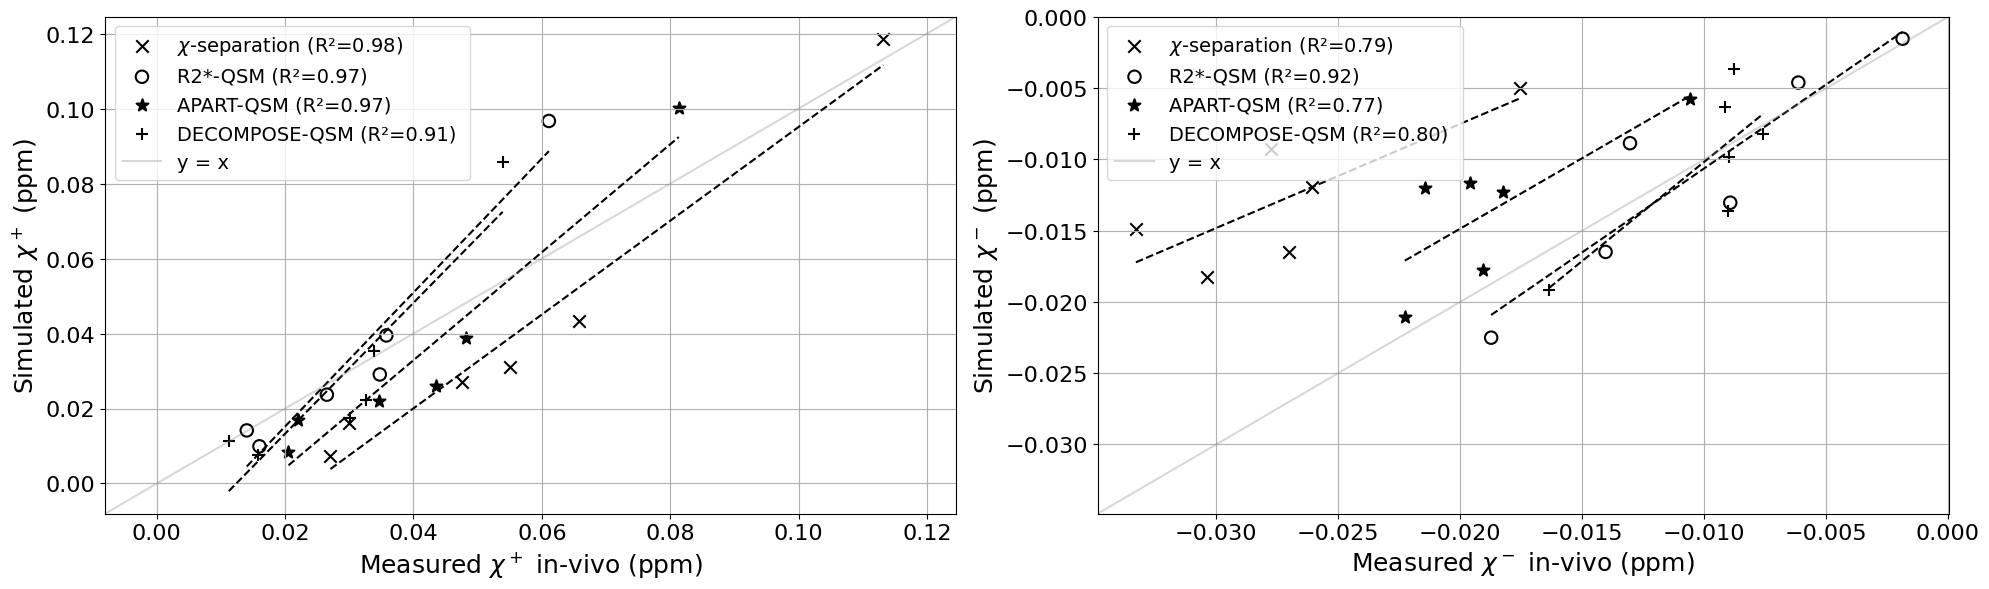

In [ ]:
# Define regions of interest
regions_of_interest = [1, 2, 3, 7, 8, 9]

# Function to extract mean values per region
def extract_mean_per_region(data_map, segmentation_map, regions):
    means = []
    for region in regions:
        region_mask = segmentation_map == region
        if np.any(region_mask):
            mean_value = np.mean(data_map[region_mask])
            means.append(mean_value)
        else:
            means.append(np.nan)  
    return means

# Load segmentation maps
segmentation_in_vivo = nib.load(base_dir / 'osfstorage' / 'Masks' / 'in_vivo_segmentation.nii.gz').get_fdata()
segmentation_simulated = nib.load(base_dir / 'osfstorage' / 'Masks' / 'SegmentedModel.nii.gz').get_fdata()

# Initialize dictionaries to store mean values
chi_positive_in_vivo_means = {}
chi_positive_simulated_means = {}
chi_negative_in_vivo_means = {}
chi_negative_simulated_means = {}

# Load data for chi-positive 

chi_positive_in_vivo_files = {
    'chi-separation': base_dir / 'osfstorage' / 'In-vivo' / 'X-separation' / 'ChiPosMap.nii',
    'R2*-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'R2star-QSM' / 'ChiPosMap.nii',
    'APART-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'APART-QSM' / 'X_para.nii',
    'DECOMPOSE-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'DECOMPOSE-QSM' / 'results_PCS.nii'
}

chi_positive_simulated_files = {
    'chi-separation': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'With_anisotropy' / 'ChiPosMap.nii',
    'R2*-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'With_anisotropy' / 'ChiPosMap.nii',
    'APART-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'With_anisotropy' / 'X_para.nii',
    'DECOMPOSE-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'With_anisotropy' / 'Results_PCS.nii'
}

# Process chi-positive 
for algo in chi_positive_in_vivo_files.keys():
    in_vivo_map = nib.load(chi_positive_in_vivo_files[algo]).get_fdata()
    simulated_map = nib.load(chi_positive_simulated_files[algo]).get_fdata()

    in_vivo_means = extract_mean_per_region(in_vivo_map, segmentation_in_vivo, regions_of_interest)
    simulated_means = extract_mean_per_region(simulated_map, segmentation_simulated, regions_of_interest)

    chi_positive_in_vivo_means[algo] = in_vivo_means
    chi_positive_simulated_means[algo] = simulated_means

# Load data for chi-negative 

chi_negative_in_vivo_files = {
    'chi-separation': base_dir / 'osfstorage' / 'In-vivo' / 'X-separation' / 'ChiNegMap.nii',
    'R2*-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'R2star-QSM' / 'ChiNegMap.nii',
    'APART-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'APART-QSM' / 'X_dia_abs.nii',
    'DECOMPOSE-QSM': base_dir / 'osfstorage' / 'In-vivo' / 'DECOMPOSE-QSM' / 'results_DCS_abs.nii'
}

chi_negative_simulated_files = {
    'chi-separation': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'With_anisotropy' / 'ChiNegMap.nii',
    'R2*-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'With_anisotropy' / 'ChiNegMap.nii',
    'APART-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'With_anisotropy' / 'X_dia_abs.nii',
    'DECOMPOSE-QSM': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'With_anisotropy' / 'Results_DCS_abs.nii'
}

# Process chi-negative data
for algo in chi_negative_in_vivo_files.keys():
    in_vivo_map = nib.load(chi_negative_in_vivo_files[algo]).get_fdata()
    in_vivo_map *= -1  
    simulated_map = nib.load(chi_negative_simulated_files[algo]).get_fdata()
    simulated_map *= -1  

    in_vivo_means = extract_mean_per_region(in_vivo_map, segmentation_in_vivo, regions_of_interest)
    simulated_means = extract_mean_per_region(simulated_map, segmentation_simulated, regions_of_interest)

    chi_negative_in_vivo_means[algo] = in_vivo_means
    chi_negative_simulated_means[algo] = simulated_means

display_names = {
    'chi-separation': r'$\chi$-separation',
    'R2*-QSM': 'R2*-QSM',
    'APART-QSM': 'APART-QSM',
    'DECOMPOSE-QSM': 'DECOMPOSE-QSM'
}

algorithms = list(chi_positive_in_vivo_files.keys())

def plot_data(in_vivo_means_dict, simulated_means_dict, chi_type, ax):
    marker_styles = ['x', 'o', '*', '+']  

    for idx, algo in enumerate(algorithms):

        x = np.array(in_vivo_means_dict[algo])
        y = np.array(simulated_means_dict[algo])
        mask = ~np.isnan(x) & ~np.isnan(y)
        x = x[mask]
        y = y[mask]

        if len(x) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            r_label = f"(R²={r_value:.2f})"
            sorted_indices = np.argsort(x)
            x_sorted = x[sorted_indices]
            y_sorted = intercept + slope * x_sorted
            ax.plot(x_sorted, y_sorted, color='black', linestyle='--', label=None)
        else:
            r_label = "(R²=NaN)"

     
        label = f"{display_names[algo]} {r_label} "

       
        marker = marker_styles[idx]
        if marker == 'x':
           
            ax.scatter(x, y, marker=marker, s=80, color='black',
                       linewidth=1.5, label=label)
        elif marker == 'o':
            
            ax.scatter(x, y, marker=marker, s=80,
                       edgecolors='black', facecolors='none',
                       linewidth=1.5, label=label)
        else:
            
            ax.scatter(x, y, marker=marker, s=80,
                       color='black', linewidth=1.5, label=label)

    # Adjust axis limits so the diagonal line covers all points
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    min_val = min(x_limits[0], y_limits[0])
    max_val = max(x_limits[1], y_limits[1])
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])

    # Draw diagonal line in grey
    ax.plot([min_val, max_val], [min_val, max_val], '-',
            color='grey',label='y = x', alpha=0.3)

    # Set axis labels and title
    ax.set_xlabel(f'Measured {chi_type} in-vivo (ppm)', fontsize=18)
    ax.set_ylabel(f'Simulated {chi_type} (ppm)', fontsize=18)
    ax.legend(loc='upper left', fontsize=14)
    ax.grid(True)

    # Adjust tick label size
    ax.tick_params(axis='both', which='major', labelsize=14)


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot chi-positive data
plot_data(chi_positive_in_vivo_means, chi_positive_simulated_means,r'$\chi^+$' , axes[0])

# Plot chi-negative data
plot_data(chi_negative_in_vivo_means, chi_negative_simulated_means,r'$\chi^-$',  axes[1])

# Adjust tick label size for both axes
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()


# Comparison between simulated vs in-vivo field maps


In [ ]:

simulated_map_path = base_dir / "osfstorage/LocalField/Simulated_Field.nii.gz"
in_vivo_map_path = base_dir / "osfstorage/LocalField/In_vivo_Field.nii.gz"
segmentation_map_path = base_dir / "osfstorage/Masks/white_matter_mask.nii.gz"

# Load the NIfTI files 
simulated_map_nii = nib.load(simulated_map_path)
in_vivo_map_nii = nib.load(in_vivo_map_path)
segmentation_map_nii = nib.load(segmentation_map_path)

# Extract the data arrays
simulated_map = simulated_map_nii.get_fdata()
in_vivo_map = in_vivo_map_nii.get_fdata()
segmentation_map = segmentation_map_nii.get_fdata()

# Extract values for scatter plot 
simulated_values = []
in_vivo_values = []

for region in range(1, 11):
    region_mask = segmentation_map == region
    simulated_region_values = simulated_map[region_mask]
    in_vivo_region_values = in_vivo_map[region_mask]

    # Take the mean value for each region
    simulated_values.append(np.mean(simulated_region_values))
    in_vivo_values.append(np.mean(in_vivo_region_values))

# Convert lists to numpy arrays for plotting
simulated_values = np.array(simulated_values)
in_vivo_values = np.array(in_vivo_values)

# Scatter plot with linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(in_vivo_values, simulated_values)
regression_line = slope * in_vivo_values + intercept

# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

# Sort the x-values (in-vivo local field values) and calculate corresponding y-values
sorted_indices = np.argsort(in_vivo_values)
sorted_in_vivo_values = in_vivo_values[sorted_indices]
sorted_regression_line = slope * sorted_in_vivo_values + intercept

# Scatter plot
ax.scatter(in_vivo_values, simulated_values, color='black', zorder=2)

# Plot the regression line with sorted values
ax.plot(sorted_in_vivo_values, sorted_regression_line, linestyle='--', color='black', linewidth=1.2, zorder=1)

# Add labels, grid, and R² text
ax.set_xlabel('In-vivo local field (Hz)', fontsize=10)
ax.set_ylabel('Simulated local field (Hz)', fontsize=10)
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, f'$R^2 = {r_value:.2f}$\nSlope = {slope:.1f}', ha='left', va='top', transform=ax.transAxes, fontsize=9)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Comparison between simulated vs in-vivo T2 maps


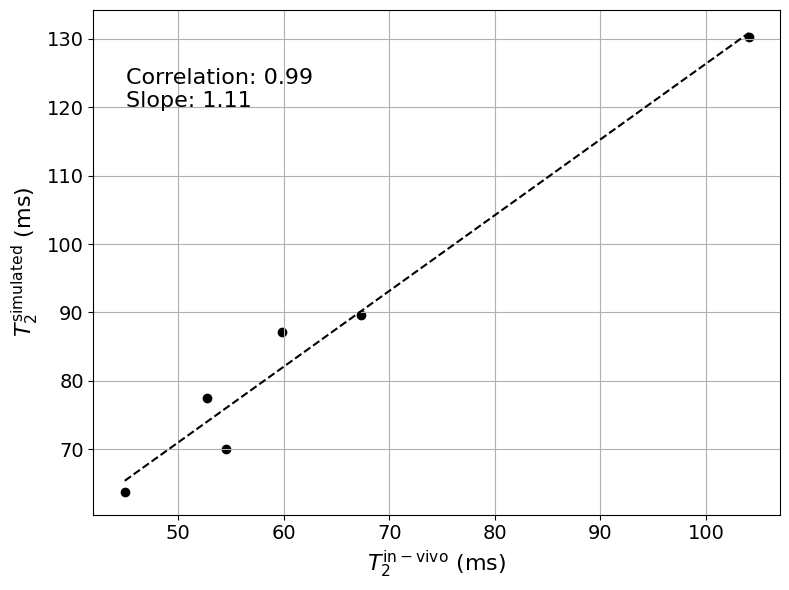

In [ ]:

# File paths for NIfTI files
in_vivo_t2_path = base_dir / "osfstorage/T2/T2_in_vivo.nii.gz"
in_vivo_segmentation_path = base_dir / "osfstorage/Masks/in_vivo_segmentation.nii.gz"
simulated_t2_path = base_dir / "osfstorage/T2/T2_simulated_resampled.nii.gz"
simulated_segmentation_path = base_dir / "osfstorage/Masks/SegmentedModel_resampled.nii.gz"

# Load NIfTI files
in_vivo_t2_map = nib.load(in_vivo_t2_path).get_fdata()
in_vivo_segmentation = nib.load(in_vivo_segmentation_path).get_fdata()
simulated_t2_map = nib.load(simulated_t2_path).get_fdata()
simulated_segmentation = nib.load(simulated_segmentation_path).get_fdata()

# Replace NaN and Inf values with 0 in the T2 maps
in_vivo_t2_map = np.nan_to_num(in_vivo_t2_map, nan=0, posinf=0, neginf=0)
simulated_t2_map = np.nan_to_num(simulated_t2_map, nan=0, posinf=0, neginf=0)

# Initialize lists for valid values
T2_in_vivo = []
T2_simulated = []

# Extract in-vivo T2 values 
for region in list(range(1, 4)) + list(range(7, 10)):  
    in_vivo_mask = in_vivo_segmentation == region
    if np.any(in_vivo_mask):  
        in_vivo_mean = np.mean(in_vivo_t2_map[in_vivo_mask])
        T2_in_vivo.append(in_vivo_mean)

# Extract simulated T2 values 
for region in list(range(1, 4)) + list(range(7, 10)):  
    simulated_mask = simulated_segmentation == region
    if np.any(simulated_mask):  
        simulated_mean = np.mean(simulated_t2_map[simulated_mask])
        T2_simulated.append(simulated_mean)

# Convert lists to numpy arrays
T2_in_vivo = np.array(T2_in_vivo)
T2_simulated = np.array(T2_simulated)

# Reshape data for linear regression
T2_in_vivo_reshaped = T2_in_vivo.reshape(-1, 1)
T2_simulated_reshaped = T2_simulated.reshape(-1, 1)

# Perform linear regression
reg_model = LinearRegression()
reg_model.fit(T2_in_vivo_reshaped, T2_simulated_reshaped)

# Regression line parameters
slope = reg_model.coef_[0][0]
intercept = reg_model.intercept_[0]

# Generate regression line values
x_fit = np.linspace(min(T2_in_vivo), max(T2_in_vivo), 100)
y_fit = slope * x_fit + intercept

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(T2_in_vivo, T2_simulated, color='black', label='Data Points')  
plt.plot(x_fit, y_fit, '--', color='black', label='Regression Line') 
plt.xlabel(r'$T_2^{\mathrm{in-vivo}}$ (ms)', fontsize=16)
plt.ylabel(r'$T_2^{\mathrm{simulated}}$ (ms)', fontsize=16)

# Add correlation and slope text with larger font
correlation = np.corrcoef(T2_in_vivo, T2_simulated)[0, 1]
plt.text(45, 120, f'Correlation: {correlation:.2f}\nSlope: {slope:.2f}', fontsize=16)

# Add grid and legend
plt.grid(visible=True)


# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


# Supplimantary Material

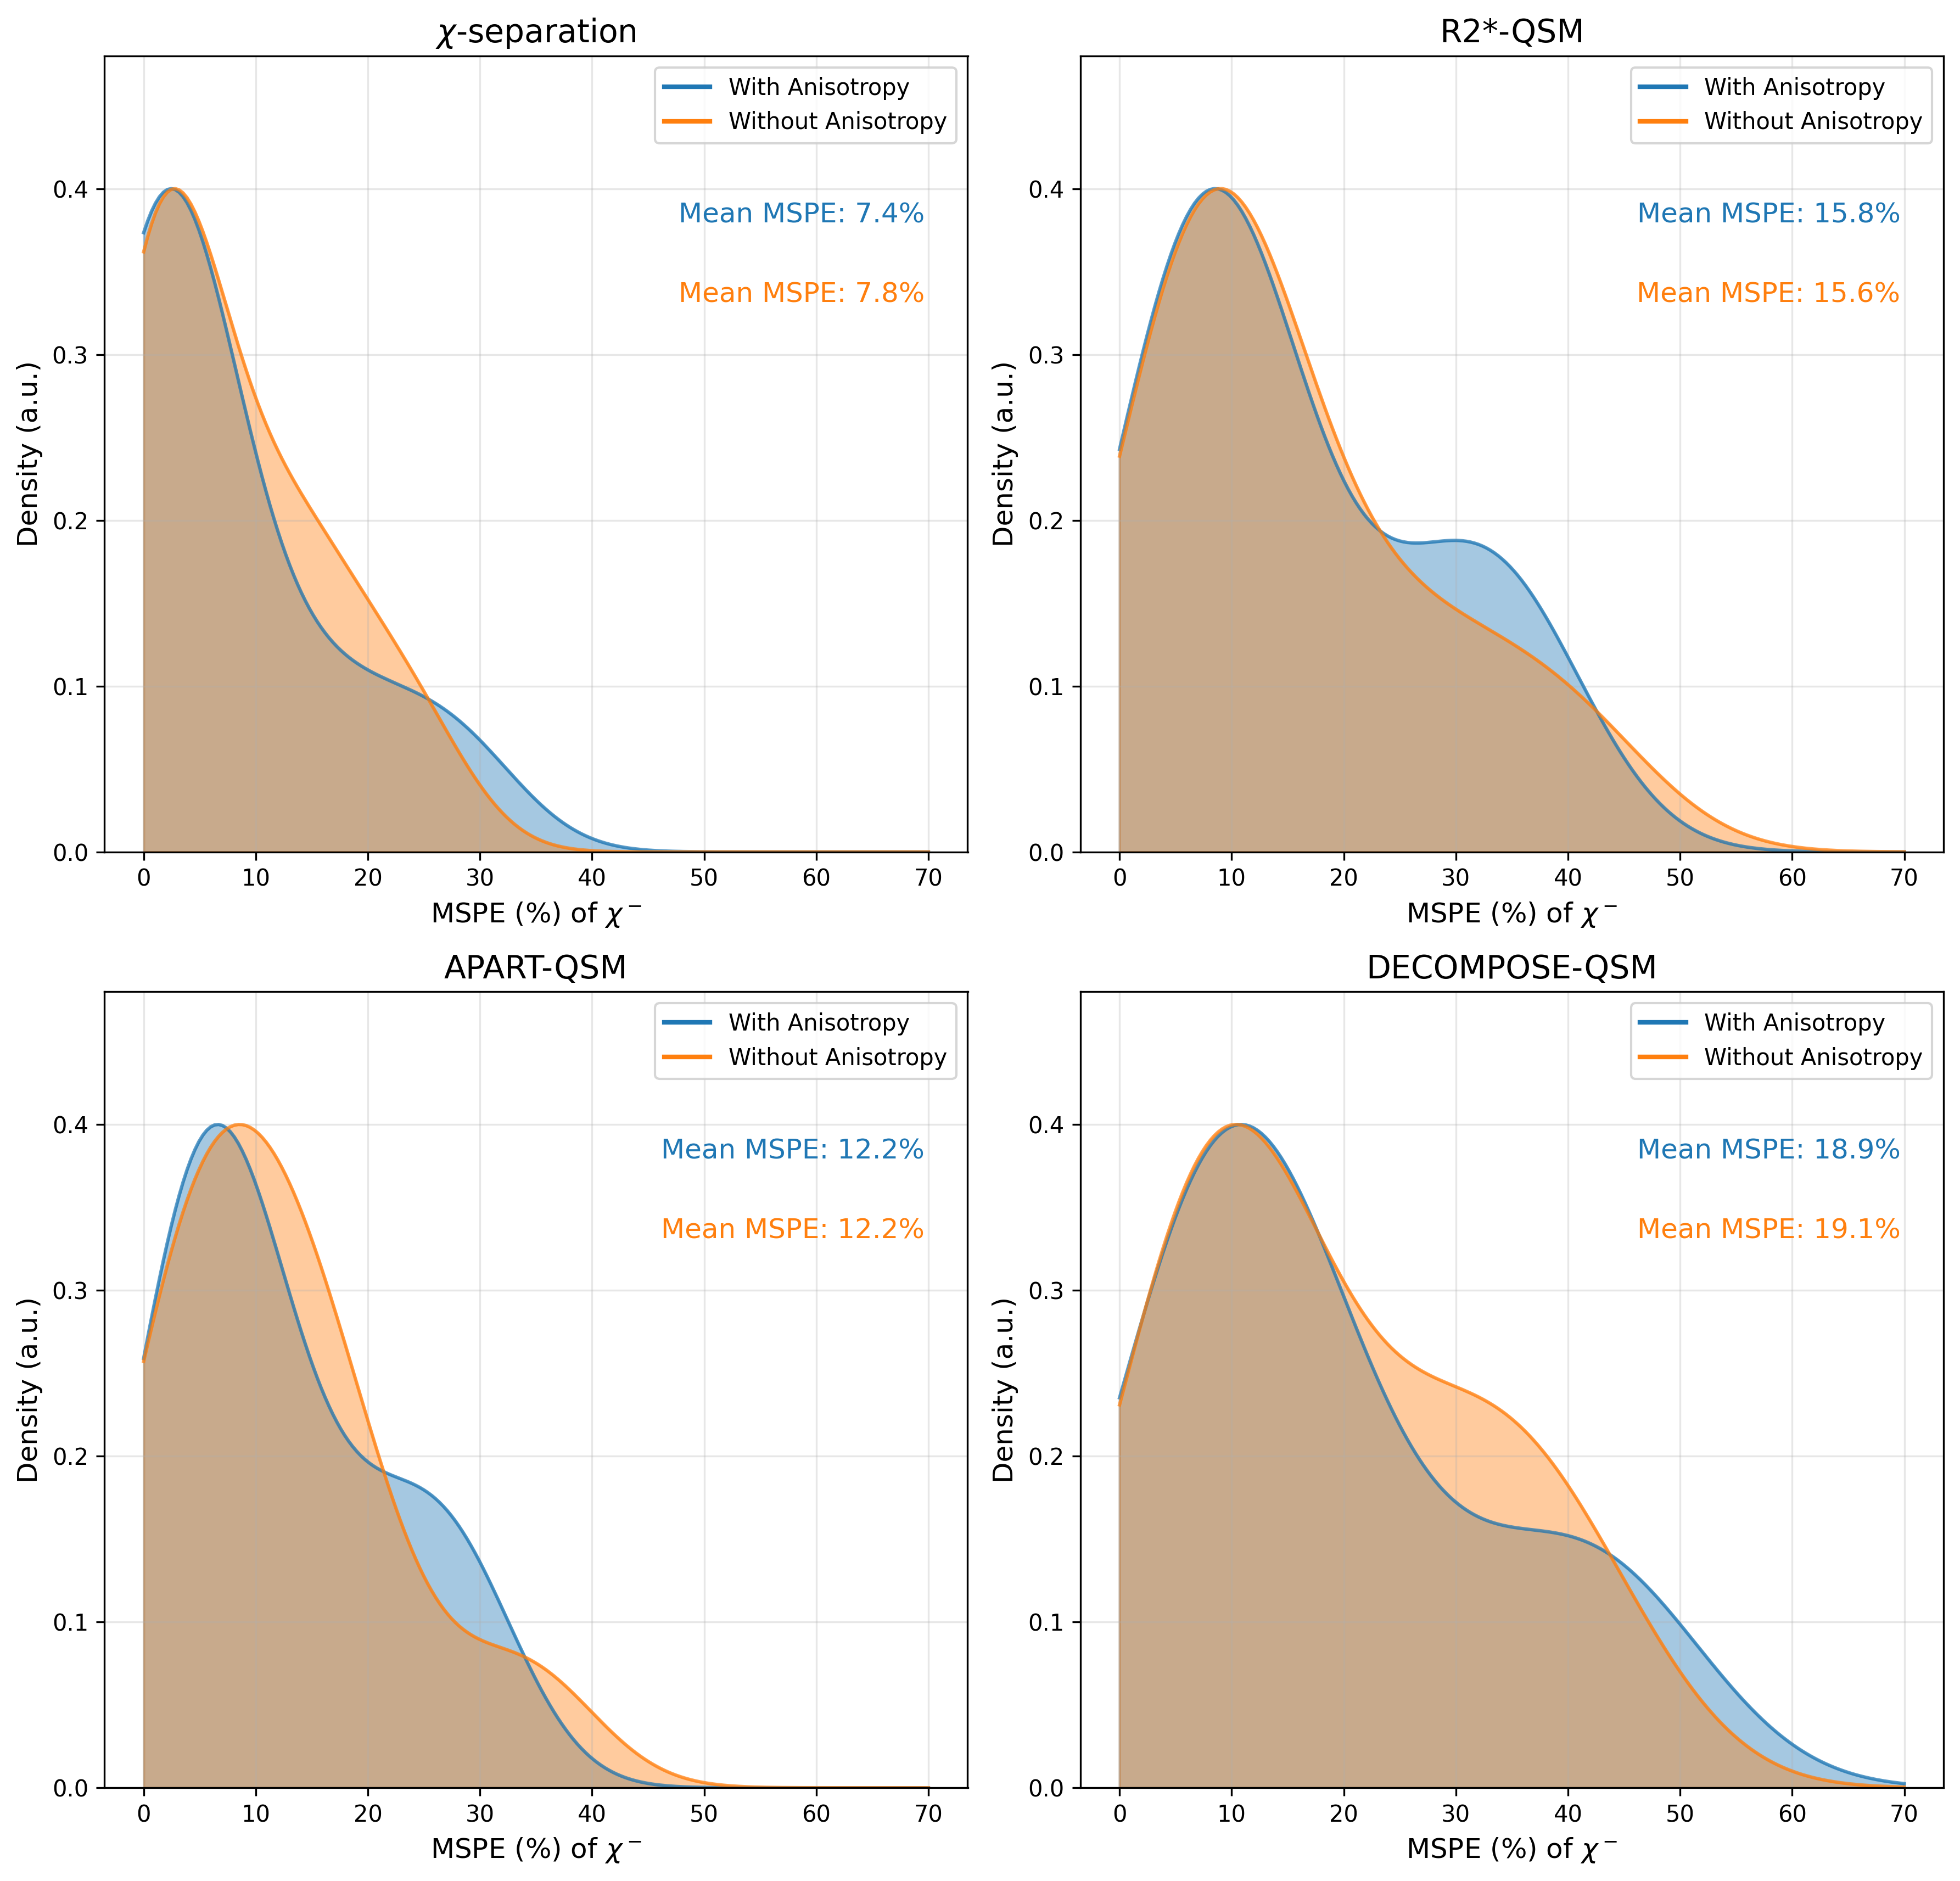

In [ ]:
# ---------------------------
# Parameters and File Paths
# ---------------------------
num_algorithms = 4
algorithm_names = [
    '$\\chi$-separation', 
    'R2*-QSM', 
    'APART-QSM', 
    'DECOMPOSE-QSM'
]

# Load segmentation mask (assumed to contain region labels 1 to 11)
segmentation2_path = base_dir / 'osfstorage' / 'Masks' / 'SegmentedModel.nii.gz'
segmentation2 = nib.load(segmentation2_path).get_fdata()
region_labels = list(range(1, 10)) 

# Load simulated maps (common for all algorithms)
simulated_with_path = base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'Chi_positive.nii.gz'
simulated_without_path = base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'Chi_positive.nii.gz'
simulated_with = nib.load(simulated_with_path).get_fdata()
simulated_without = nib.load(simulated_without_path).get_fdata()

# Define measured maps for each algorithm
measured_maps = {
    0: {  # Algorithm 1: χ-separation
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'With_anisotropy' / 'ChiPosMap.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'Without_anisotropy' / 'ChiPosMap.nii',
    },
    1: {  # Algorithm 2: R2*-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'With_anisotropy' / 'ChiPosMap.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'Without_anisotropy' / 'ChiPosMap.nii',
    },
    2: {  # Algorithm 3: APART-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'With_anisotropy' / 'X_para.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'Without_anisotropy' / 'X_para.nii',
    },
    3: {  # Algorithm 4: DECOMPOSE-QSM
        'x_minus_with_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'With_anisotropy' / 'Results_PCS.nii',
        'x_minus_without_anisotropy': base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'Without_anisotropy' / 'results_PCS.nii',
    },
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi=300)

for idx in range(num_algorithms):
    ax = axes[idx // 2, idx % 2]
    algorithm_name = algorithm_names[idx]
    
    measured_with = nib.load(measured_maps[idx]['x_minus_with_anisotropy']).get_fdata() 
    measured_without = nib.load(measured_maps[idx]['x_minus_without_anisotropy']).get_fdata() 

    errors_with_regions = []
    errors_without_regions = []
    
    for region in region_labels:
        region_mask = segmentation2 == region
        if np.any(region_mask):
            # For "With Anisotropy"
            sim_val_with = np.mean(simulated_with[region_mask])
            meas_val_with = np.mean(measured_with[region_mask])
            if sim_val_with != 0:
                error_with = ((meas_val_with - sim_val_with) / sim_val_with) ** 2 * 100
            else:
                error_with = np.nan
        
            # For "Without Anisotropy"
            sim_val_without = np.mean(simulated_without[region_mask])
            meas_val_without = np.mean(measured_without[region_mask])
            if sim_val_without != 0:
                error_without = ((meas_val_without - sim_val_without) / sim_val_without) ** 2 * 100
            else:
                error_without = np.nan
           
            errors_with_regions.append(error_with)
            errors_without_regions.append(error_without)
    
    # Convert to numpy arrays and remove NaNs
    errors_with_regions = np.array(errors_with_regions)
    errors_without_regions = np.array(errors_without_regions)
    errors_with_regions = errors_with_regions[~np.isnan(errors_with_regions)]
    errors_without_regions = errors_without_regions[~np.isnan(errors_without_regions)]
    
    x_vals = np.linspace(0, 70, 200)  
    max_height = 0.4 
    
    # Plot KDE for "With Anisotropy"
    if errors_with_regions.size > 1:
        kde_with = gaussian_kde(errors_with_regions)
        density_with = kde_with(x_vals)
        scaling_with = max_height / np.max(density_with) if np.max(density_with) > 0 else 1
        density_with_scaled = density_with * scaling_with
        ax.fill_between(x_vals, 0, density_with_scaled, color='tab:blue', alpha=0.4)
        ax.plot(x_vals, density_with_scaled, color='tab:blue', alpha=0.7)
        mean_mspe_with = np.mean(errors_with_regions)
    elif errors_with_regions.size == 1:
        mean_mspe_with = errors_with_regions[0]
        ax.plot([mean_mspe_with], [max_height/2], marker='o', color='tab:blue')
    else:
        mean_mspe_with = None  # no data available

    # Plot KDE for "Without Anisotropy"
    if errors_without_regions.size > 1:
        kde_without = gaussian_kde(errors_without_regions)
        density_without = kde_without(x_vals)
        scaling_without = max_height / np.max(density_without) if np.max(density_without) > 0 else 1
        density_without_scaled = density_without * scaling_without
        ax.fill_between(x_vals, 0, density_without_scaled, color='tab:orange', alpha=0.4)
        ax.plot(x_vals, density_without_scaled, color='tab:orange', alpha=0.7)
        mean_mspe_without = np.mean(errors_without_regions)
    elif errors_without_regions.size == 1:
        mean_mspe_without = errors_without_regions[0]
        ax.plot([mean_mspe_without], [max_height/2], marker='o', color='tab:orange')
    else:
        mean_mspe_without = None


    if mean_mspe_with is not None:
        ax.text(0.95, 0.8, f"Mean MSPE: {mean_mspe_with:.1f}%", transform=ax.transAxes,
                color='tab:blue', ha='right', va='center', fontsize=12)
    if mean_mspe_without is not None:
        ax.text(0.95, 0.7, f"Mean MSPE: {mean_mspe_without:.1f}%", transform=ax.transAxes,
                color='tab:orange', ha='right', va='center', fontsize=12)
    
    # ------------------------------------------------
    # Create and add a legend for the subplot
    # ------------------------------------------------
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=2, label='With Anisotropy'),
        Line2D([0], [0], color='tab:orange', lw=2, label='Without Anisotropy')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Set title and axis labels.
    ax.set_title(algorithm_name, fontsize=14)
    ax.set_xlabel("MSPE (%) of $\\chi^+$", fontsize=12)
    ax.set_ylabel("Density (a.u.)", fontsize=12)
    #ax.set_xlim(0, 70)
    ax.set_ylim(0, max_height * 1.2)
    ax.grid(alpha=0.3)

# ---------------------------
# Final figure adjustments
# ---------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


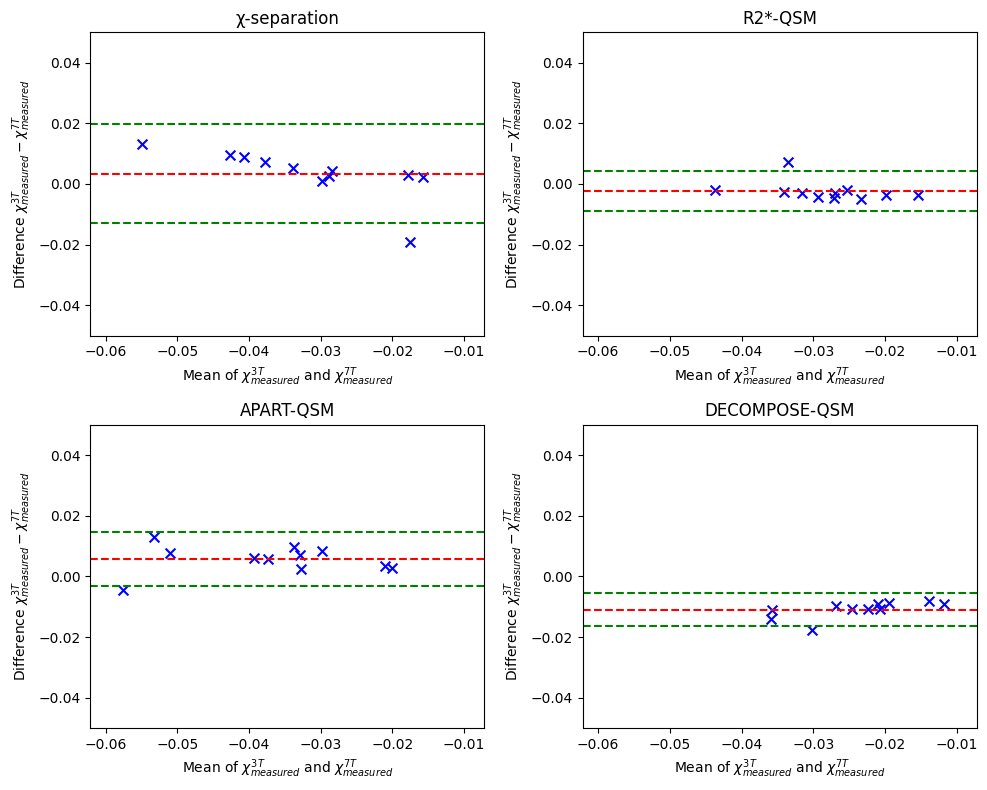

In [ ]:
methods = {
    "χ-separation":   (base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'X-separation' / 'With_anisotropy' / 'ChiNegMap.nii',   base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' /'7T' /'X-separation' /'ChiNegMap.nii'),
    "R2*-QSM":        (base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'R2star-QSM' / 'With_anisotropy' / 'ChiNegMap.nii',base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' /'7T' /'' 'R2star-QSM'/ 'ChiNegMap.nii'),
    "APART-QSM":      (base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'APART-QSM' / 'With_anisotropy' / 'X_dia_abs.nii', base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / '7T' /'APART-QSM'  / 'X_dia_abs.nii'),
    "DECOMPOSE-QSM":  (base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / 'DECOMPOSE-QSM' / 'With_anisotropy' / 'Results_DCS_abs.nii', base_dir / 'osfstorage' / 'Susceptibility_Separation_Results' / '7T' /'DECOMPOSE-QSM' / 'Results_DCS_abs.nii')
}

#-----------------------------------------------------------------
# Load segmentation file
#-----------------------------------------------------------------
segmentation_file = base_dir / "osfstorage/Masks/white_matter_mask.nii.gz"
seg_nii  = nib.load(segmentation_file)
seg_data = seg_nii.get_fdata()


labels = range(1, 12)
method_points = {}  
all_mean_values = []
all_difference_values = []

for method_name, (nii_3T_path, nii_7T_path) in methods.items():
    # --------------------
    # Load the 3T and 7T
    # --------------------
    nii_3T = nib.load(nii_3T_path)
    nii_7T = nib.load(nii_7T_path)
    
    data_3T = nii_3T.get_fdata()*-1
    data_7T = nii_7T.get_fdata()*-1
        
    mean_values = np.zeros(len(labels))
    diff_values = np.zeros(len(labels))
    
    for i, label_val in enumerate(labels):
        # Mask for current region
        mask = (seg_data == label_val)
        
        # Extract the region's data for 3T and 7T
        region_3T = data_3T[mask]
        region_7T = data_7T[mask]
        
        # Compute the mean within that region
        mean_3T = np.mean(region_3T) if region_3T.size > 0 else np.nan
        mean_7T = np.mean(region_7T) if region_7T.size > 0 else np.nan
        
        # Bland-Altman points
        mean_values[i] = (mean_3T + mean_7T) / 2
        diff_values[i] = (mean_3T - mean_7T)
    
    # Store in dictionary
    method_points[method_name] = (mean_values, diff_values)
    
    # Accumulate for global axis limits
    all_mean_values.extend(mean_values)
    all_difference_values.extend(diff_values)

# Convert to NumPy for min/max
all_mean_values = np.array(all_mean_values)
all_difference_values = np.array(all_difference_values)

x_min, x_max = np.min(all_mean_values), np.max(all_mean_values)
x_margin = 0.1 * (x_max - x_min)  # 10% margin
x_lim = (x_min - x_margin, x_max + x_margin)


y_lim = (-0.05, 0.05)


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (method_name, (mean_values, difference_values)) in zip(axes, method_points.items()):
    # Mean and Limits of Agreement
    mean_diff = np.mean(difference_values)
    std_diff  = np.std(difference_values, ddof=1)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff
    
    # Scatter: 10 points per method
    ax.scatter(mean_values, difference_values, color="blue", marker="x", s=50)
    ax.axhline(mean_diff, color="red", linestyle="--", label="Mean difference")
    ax.axhline(loa_upper, color="green", linestyle="--", label="+1.96 SD")
    ax.axhline(loa_lower, color="green", linestyle="--", label="-1.96 SD")
    
    ax.set_xlabel(r"Mean of $\chi^{3T}_{measured}$ and $\chi^{7T}_{measured}$")
    ax.set_ylabel(r"Difference $\chi^{3T}_{measured} - \chi^{7T}_{measured}$")
    ax.set_title(method_name)
    
    # Set global axis limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

plt.tight_layout()
plt.savefig("bland_altman_4methods.png", dpi=300, bbox_inches="tight")
plt.show()
